# Random Search for CNN Hyperparameter optimization on CIFAR-10

## Setup and Imports

### Import necessary libraries

In [1]:
# First, uninstall all existing packages to avoid conflicts
!pip uninstall -y tensorflow tensorflow-addons keras

# Install a more recent version of TensorFlow that works better with modern CUDA
!pip install tensorflow==2.12.0
!pip install tensorflow-addons
!pip install matplotlib scikit-learn scipy

# Set environment variable to bypass some compatibility warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import the necessary libraries
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import classification_report
import scipy.stats as stats
import time
import os

# Verify GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())

# Configure TensorFlow to use GPU memory efficiently
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print("Error setting memory growth:", e)

Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
Found existing installation: keras 2.14.0
Uninstalling keras-2.14.0:
  Successfully uninstalled keras-2.14.0
  Obtaining dependency information for tensorflow==2.12.0 from https://files.pythonhosted.org/packages/6b/6d/00ef55900312ba8c8aa9d64b13c74fb8cba0afa24cc4a2ce74796f530244/tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for gast<=0.4.0,>=0.2.1 from https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for jax>=0.3.15 from https://files.pythonhosted.org/packages/86/bb/fdc6513a9aada13fd21e9860e2adee5f6eea2b4f0a145b219288875acb26/jax-0.5.3-py3-none-any.whl.metadata
  Obtaining dependency information for keras<2.13,>=2.12.0 from https://files.pythonhosted.org/packages/

### Set send for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Data Loading

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
# Display dataset dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [5]:
def plot_sample(X, y, index):
  plt.figure(figsize = (15,2))
  plt.imshow(X[index])
  plt.xlabel(classes[y[index]])


## Preprocessing

In [6]:
# Normalize the data (scale pixel values between 0 and 1)
X_train = X_train.astype('float32')/ 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
# Reshape labels from (n, 1) to (n,) format
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [8]:
# Convert labels to one-hot encoding (categorical format)
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=10)

### Data visualisation

In [9]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

### Data Augmentation

In [10]:
# Data augmentation helps prevent overfitting by creating modified versions of training images
datagen = ImageDataGenerator (
    rotation_range=15,      # Random rotation up to 15 degrees
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1, # Random vertical shifts
    horizontal_flip=True,   # Random horizontal flips
    zoom_range=0.1,         # Random zoom
    fill_mode='nearest'     # Strategy for filling newly created pixels
)

In [11]:
# Main augmentation function
def create_augmentation_strategy(strategy='standard'):
    """
    Create an augmentation strategy based on the specified parameter
    
    Args:
        strategy: One of 'standard', 'cutoff', 'mixup', 'cutmix'
    
    Returns:
        A standard ImageDataGenerator
    """
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest'
    )

In [12]:
# Fit the data generator on the training data
datagen.fit(X_train)

In [13]:
# Visualise the augmentation on a single image
def visualise_augmentation(X_sample):
    plt.figure(figsize=(12, 6))
    
    # Display original image
    plt.subplot(2, 3, 1)
    plt.imshow(X_sample)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display 5 augmented versions
    img_tensor = np.expand_dims(X_sample, axis=0) # Add the batch dimension
    i = 2
    for batch in datagen.flow(img_tensor, batch_size=1):
        plt.subplot(2, 3, i)
        plt.imshow(batch[0])
        plt.title(f"Augmented {i-1}")
        plt.axis('off')
        
        i += 1
        if i > 6:
            break
     
    plt.tight_layout()
    plt.show()


## Hyperparameter Search Space Definitions

In [14]:
# Define the hyperparameter search space
param_distributions = {
    # Most important
    'learning_rate': stats.loguniform(1e-4, 5e-4), # Now focused around best value
    
    # Second important
    'batch_size': [128, 256], # Keeping the best and trying larger
    'momentum': [0.9], # For SGD (not used with Adam/Adamw)
    'units_per_layer': [512, 768, 1024], # Now increasing capacity
    
    # Third important
    'learning_rate_decay': [0.0], # Handled by schedulers now
    'learning_rate_schedule': ['cosine_decay', 'exponential_decay'],
    'num_layers': [3, 4, 5], # Now trying deeoer networks
    
    # Fourth important
    'optimizer': ['adam', 'adamw'],# Adding Adamw
    
    # Fixed parameters (not part of the search)
    'l2_reg': [0.001, 0.0005], # Trying different L2 regularization values
    'dropout_rate': [0.25, 0.3, 0.4], # Trying out higher rates
    'epochs': [40], # Increase max epochs with early stopping
}

In [15]:
# Explain the search space
print("Hyperparameter search space:")
for param, values in param_distributions.items():
    if hasattr(values, "rvs"):
        if param == 'learning_rate':
            print(f"- {param}: Sampled from log-uniform distribution between 0.0001 and 0.1-")
        elif param == 'momentum':
            print(f"- {param}: Sampled from uniform distribution between 0.8 and 0.99")
        else:
            print(f"- {param}: Sampled from distribution")
    else:
        print(f"- {param}: {values}")

Hyperparameter search space:
- learning_rate: Sampled from log-uniform distribution between 0.0001 and 0.1-
- batch_size: [128, 256]
- momentum: [0.9]
- units_per_layer: [512, 768, 1024]
- learning_rate_decay: [0.0]
- learning_rate_schedule: ['cosine_decay', 'exponential_decay']
- num_layers: [3, 4, 5]
- optimizer: ['adam', 'adamw']
- l2_reg: [0.001, 0.0005]
- dropout_rate: [0.25, 0.3, 0.4]
- epochs: [40]


## Model Architecture Definition

In [16]:
def create_model(params):
    """
    Create a CNN model with RestNet-style architecture
    """
    
    inputs = keras.Input(shape=(32, 32, 3))
    
    # Initial conv layer
    x = layers.Conv2D(32, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(params['l2_reg']))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Add RestNet blocks based on num_layers parameters
    for i in range(params['num_layers']):
        # Store input for skip connection
        input_tensor = x
        
        # First conv in block
        x = layers.Conv2D(params['units_per_layer']//4, (3, 3), padding='same',
                         kernel_regularizer=regularizers.l2(params['l2_reg']))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
                                
        # Second conv in block
        x = layers.Conv2D(params['units_per_layer']//4, (3, 3), padding='same',
                         kernel_regularizer=regularizers.l2(params['l2_reg']))(x)
        x = layers.BatchNormalization()(x)
        
        # Add skip connection (with projection if needed)
        if input_tensor.shape[-1] != params['units_per_layer']//4:
            input_tensor = layers.Conv2D(params['units_per_layer']//4, (1, 1), padding='same')(input_tensor)
                                
        x = layers.Add()([x, input_tensor])
        x = layers.Activation('relu')(x)
        
        # Downsample after each block (except the last one)
        if i < params['num_layers'] - 1:
            x = layers.MaxPooling2D((2, 2))(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(params['dropout_rate'])(x)
    x = layers.Dense(params['units_per_layer'], activation='relu',
                    kernel_regularizer=regularizers.l2(params['l2_reg']))(x)
    outputs = layers.Dense(10, activation='softmax')(x)
                                
    model = keras.Model(inputs, outputs)
    
    # Configuration optimizer
    if params['optimizer'] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'adamw':
        optimizer = tfa.optimizers.Adamw(
            learning_rate=params['learning_rate'],
            weight_decay=params['l2_reg']
        )
    else:
        optimizer = optimizers.SGD(
            learning_rate=params['learning_rate'],
            momentum=params['momentum'],
            decay=params['learning_rate_decay']
        )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [17]:
# Test model with a sample set of parameters
print("\nCreat ing a sample model to verify architecture")
sample_params = {
    'learning_rate': 0.001,
    'batch_size': 64,
    'momentum': 0.9,
    'units_per_layer': 64,
    'learning_rate_decay': 0.0,
    'learning_rate_schedule': 'cosine_decay',
    'units_per_layer': 512,
    'num_layers': 3,
    'optimizer': 'adam',
    'momentum': 0.9,
    'l2_reg': 0.001,
    'dropout_rate': 0.3,
    'epochs': 40
}

sample_model = create_model(sample_params)
sample_model.summary()


Creat ing a sample model to verify architecture
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32

## Model Training and Evaluation function

In [18]:
def evaluate_model(params):
    """
    Train and evaluate a model with the specified hyperparameters
    
    Args:
        params: Dictionary containing hyperparameter values
    
    Returns:
        Dictionary containing model, history, and evaluation results
    """
    print(f"\nTraining with parameters: {params}")
    
    # Create and compile model
    model = create_model(params)
    
    # Setup callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
    ]
    
    # Add learning rate scheduler if specified
    if params.get('learning_rate_schedule') == 'cosine_decay':
        # Calculate decay steps as total number of batches over all epochs
        decay_steps = int(len(X_train) / params['batch_size']) * params['epochs']
        lr_scheduler = keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=params['learning_rate'],
            decay_steps=decay_steps
        )
        callbacks.append(
            keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr_scheduler(model.optimizer.iterations))
        )
    elif params.get('learning_rate_schedule') == 'exponential_decay':
        callbacks.append(
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        )
        
    # Create data generator with standard augmentation
    datagen = create_augmentation_strategy()
    datagen.fit(X_train)
    
    # Train the model with augmentation
    start_time = time.time()
    
    history = model.fit(
        datagen.flow(X_train, y_train_categorical, batch_size=params['batch_size']),
        steps_per_epoch=len(X_train) // params['batch_size'],
        epochs=params['epochs'],
        validation_data=(X_test, y_test_categorical),
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Get more detailed metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Return results
    return {
        'model': model,
        'history': history,
        'test_accuracy': test_acc,
        'params': params,
        'y_pred': y_pred_classes,
        'training_time': training_time
    }

## Random Search Implementation

In [19]:
# Create parameter combinations using ParameterSampler
# For demonstration, we'll use a smaller number, but increase for real tuning
n_iter = 20  # Increase to 20+ for actual training
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))

# Display sampled parameter combinations
print(f"\nGenerated {n_iter} random hyperparameter combinations:")
for i, params in enumerate(param_list):
    print(f"\nCombination {i+1}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

# Run the random search
results = []

print(f"\n======= STARTING RANDOM SEARCH WITH {n_iter} COMBINATIONS =======")
start_time = time.time()

for i, params in enumerate(param_list):
    print(f"\n---------- Combination {i+1}/{n_iter} ----------")
    try:
        result = evaluate_model(params)
        print("Model evaluation completed successfully") 
        results.append(result)
        
        # Check the length of results after each append
        print(f"Number of results so far: {len(results)}") 
        
        # Print current best model
        if len(results) > 0:  # Add this check
            best_idx = np.argmax([r['test_accuracy'] for r in results])
            print(f"\nBest model so far: {results[best_idx]['test_accuracy']:.4f} accuracy")
            print(f"Best parameters: {results[best_idx]['params']}")
        
    except Exception as e:
        print(f"Error with parameters {params}: {e}")

end_time = time.time()
total_time = end_time - start_time
print(f"\nRandom search completed in {total_time / 60:.2f} minutes")


Generated 20 random hyperparameter combinations:

Combination 1:
  batch_size: 128
  dropout_rate: 0.25
  epochs: 40
  l2_reg: 0.001
  learning_rate: 0.0003248192869770287
  learning_rate_decay: 0.0
  learning_rate_schedule: cosine_decay
  momentum: 0.9
  num_layers: 3
  optimizer: adam
  units_per_layer: 768

Combination 2:
  batch_size: 128
  dropout_rate: 0.4
  epochs: 40
  l2_reg: 0.001
  learning_rate: 0.0002094118242147359
  learning_rate_decay: 0.0
  learning_rate_schedule: cosine_decay
  momentum: 0.9
  num_layers: 5
  optimizer: adamw
  units_per_layer: 512

Combination 3:
  batch_size: 256
  dropout_rate: 0.3
  epochs: 40
  l2_reg: 0.0005
  learning_rate: 0.00010012541610724887
  learning_rate_decay: 0.0
  learning_rate_schedule: exponential_decay
  momentum: 0.9
  num_layers: 3
  optimizer: adam
  units_per_layer: 768

Combination 4:
  batch_size: 256
  dropout_rate: 0.25
  epochs: 40
  l2_reg: 0.0005
  learning_rate: 0.00010378149997045538
  learning_rate_decay: 0.0
  lear

## Results and Analysis

In [20]:
# Find the best model
best_idx = np.argmax([r['test_accuracy'] for r in results])
best_result = results[best_idx]

print("\n========== BEST MODEL ==========")
print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
print("\nBest Hyperparameters:")
for param, value in best_result['params'].items():
    print(f"- {param}: {value}")

# Generate classification report for the best model
print("\nClassification Report:")
report = classification_report(y_test, best_result['y_pred'])
print(report)



========== BEST MODEL ==========
Test Accuracy: 0.9191

Best Hyperparameters:
- batch_size: 128
- dropout_rate: 0.3
- epochs: 40
- l2_reg: 0.0005
- learning_rate: 0.0002920517093676461
- learning_rate_decay: 0.0
- learning_rate_schedule: exponential_decay
- momentum: 0.9
- num_layers: 4
- optimizer: adam
- units_per_layer: 1024

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1000
           1       0.91      0.98      0.95      1000
           2       0.93      0.87      0.90      1000
           3       0.81      0.87      0.84      1000
           4       0.94      0.92      0.93      1000
           5       0.94      0.81      0.87      1000
           6       0.91      0.97      0.94      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.93      0.95      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.92     1

### Learning Curves Visualisation

Text(0.5, 1.05, 'Learning Curves for the Best Model')

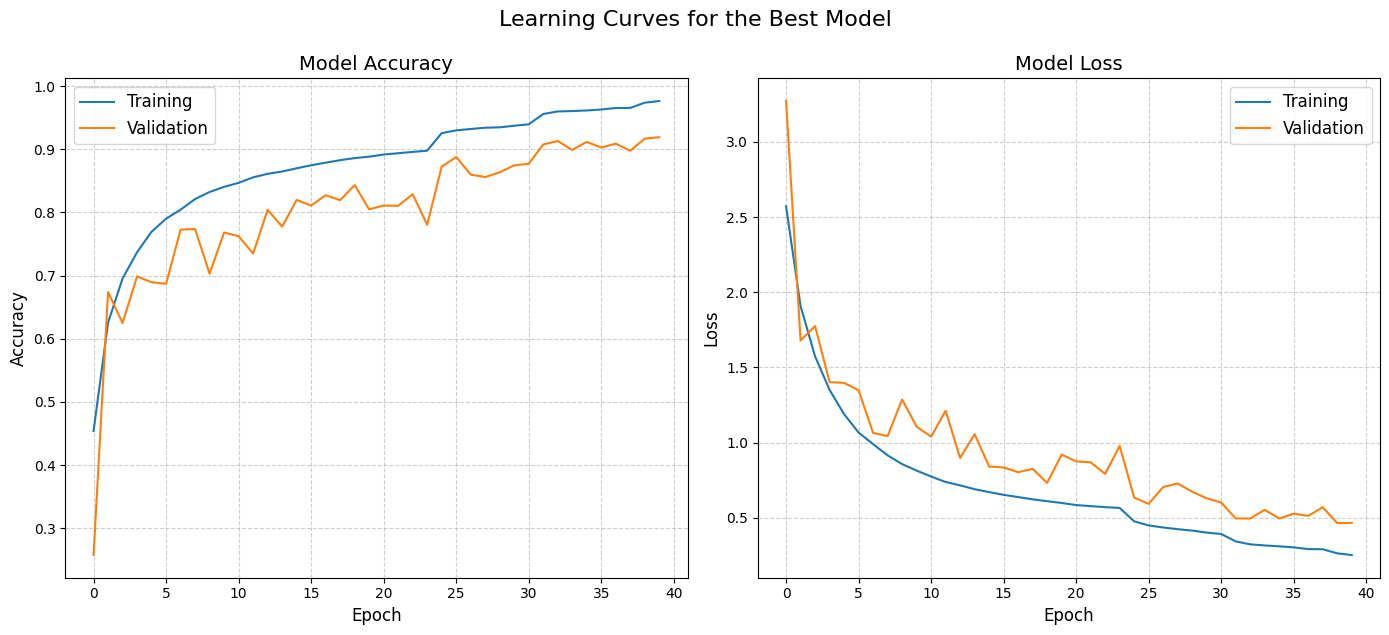

In [21]:
# Plot learning curves for the best model
plt.figure(figsize=(14, 6))

# Plot accuracy curves
plt.subplot(1, 2, 1)
plt.plot(best_result['history'].history['accuracy'], label='Training')
plt.plot(best_result['history'].history['val_accuracy'], label='Validation')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(best_result['history'].history['loss'], label='Training')
plt.plot(best_result['history'].history['val_loss'], label='Validation')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()
plt.suptitle('Learning Curves for the Best Model', y=1.05, fontsize=16)

### Model Comparison

In [22]:
# Create a table comparing all models
print("\n========= ALL MODELS COMPARISON =========")
all_results = []
for i, result in enumerate(results):
    all_results.append({
        'combination': i+1,
        'accuracy': result['test_accuracy'],
        'learning_rate': result['params']['learning_rate'],
        'batch_size': result['params']['batch_size'],
        'optimizer': result['params']['optimizer'],
        'momentum': result['params'].get('momentum', 'N/A') if result['params']['optimizer'] == 'sgd' else 'N/A',
        'units_per_layer': result['params']['units_per_layer'],
        'num_layers': result['params']['num_layers'],
        'learning_rate_decay': result['params']['learning_rate_decay'],
        'training_time': result.get('training_time', 'N/A')
    })
# Sort by accuracy in descending order
all_results.sort(key=lambda x: x['accuracy'], reverse=True)

# Print all models
print("\nRanked Models by Accuracy:")
for i, result in enumerate(all_results):
    print(f"\nRank {i+1}: Accuracy = {result['accuracy']:.4f}")
    print(f"  Learning Rate: {result['learning_rate']:.6f}")
    print(f"  Batch Size: {result['batch_size']}")
    print(f"  Optimizer: {result['optimizer']}")
    if result['optimizer'] == 'sgd':
        print(f"  Momentum: {result['momentum']}")
    print(f"  Units Per Layer: {result['units_per_layer']}")
    print(f"  Number of Layers: {result['num_layers']}")
    print(f"  Learning Rate Decay: {result['learning_rate_decay']}")
    print(f"  Training Time: {result['training_time']:.2f} seconds" if result['training_time'] != 'N/A' else "  Training Time: N/A")
    



========= ALL MODELS COMPARISON =========

Ranked Models by Accuracy:

Rank 1: Accuracy = 0.9191
  Learning Rate: 0.000292
  Batch Size: 128
  Optimizer: adam
  Units Per Layer: 1024
  Number of Layers: 4
  Learning Rate Decay: 0.0
  Training Time: 509.17 seconds

Rank 2: Accuracy = 0.9162
  Learning Rate: 0.000399
  Batch Size: 256
  Optimizer: adam
  Units Per Layer: 1024
  Number of Layers: 3
  Learning Rate Decay: 0.0
  Training Time: 498.50 seconds

Rank 3: Accuracy = 0.9152
  Learning Rate: 0.000325
  Batch Size: 128
  Optimizer: adam
  Units Per Layer: 768
  Number of Layers: 3
  Learning Rate Decay: 0.0
  Training Time: 546.96 seconds

Rank 4: Accuracy = 0.9146
  Learning Rate: 0.000346
  Batch Size: 256
  Optimizer: adam
  Units Per Layer: 768
  Number of Layers: 4
  Learning Rate Decay: 0.0
  Training Time: 497.84 seconds

Rank 5: Accuracy = 0.9134
  Learning Rate: 0.000221
  Batch Size: 128
  Optimizer: adam
  Units Per Layer: 768
  Number of Layers: 5
  Learning Rate Decay

### Hyperparameter Impact Visualisation

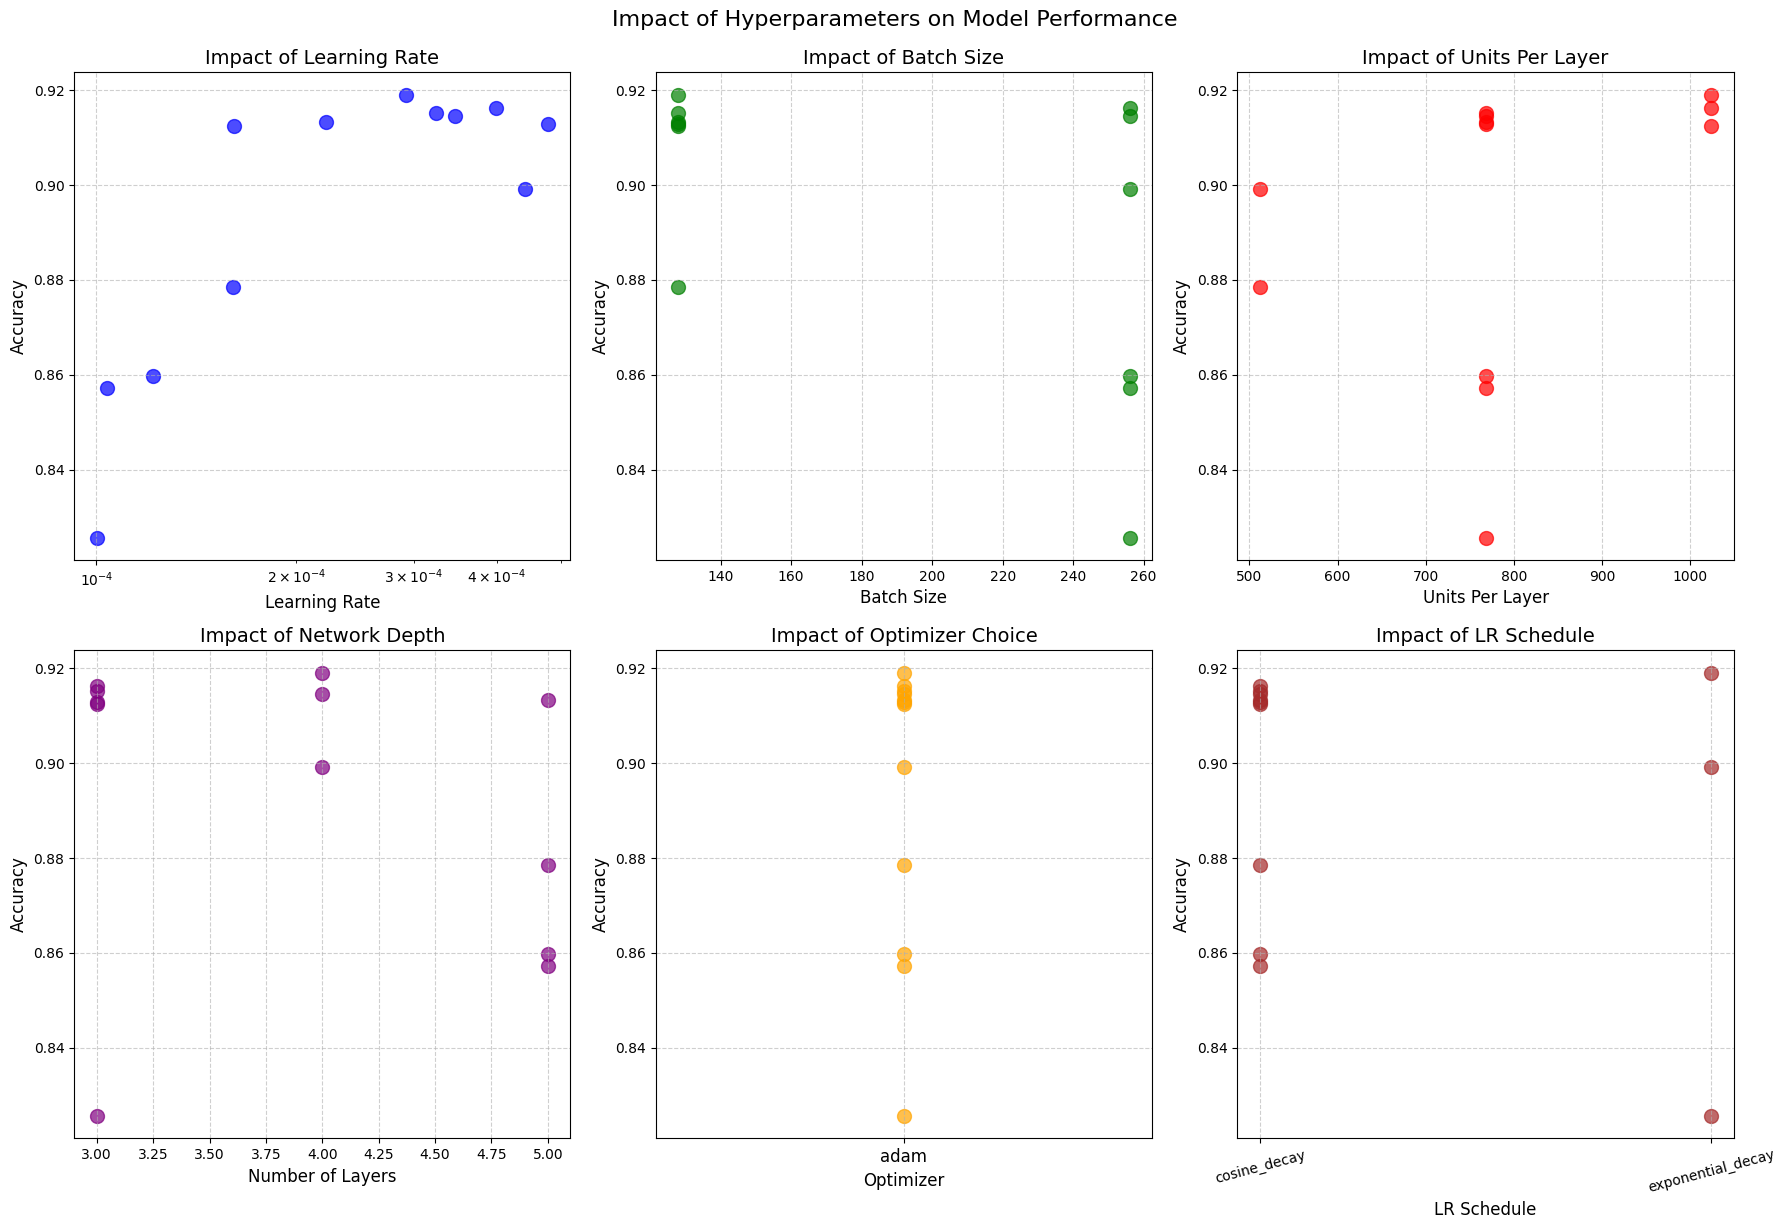

In [23]:
# Only create visualizations if we have results
if len(results) > 0:
    plt.figure(figsize=(18, 12))
    
    # Learning rate vs accuracy
    plt.subplot(2, 3, 1)
    lr_values = [r['params']['learning_rate'] for r in results]
    acc_values = [r['test_accuracy'] for r in results]
    plt.scatter(lr_values, acc_values, s=100, color='blue', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Learning Rate', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Impact of Learning Rate', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Batch_size vs accuracy
    plt.subplot(2, 3, 2)
    batch_values = [r['params']['batch_size'] for r in results]
    plt.scatter(batch_values, acc_values, s=100, color='green', alpha=0.7)
    plt.xlabel('Batch Size', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Impact of Batch Size', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Units per layer vs accuracy
    plt.subplot(2, 3, 3)
    units_values = [r['params']['units_per_layer'] for r in results]
    plt.scatter(units_values, acc_values, s=100, color='red', alpha=0.7)
    plt.xlabel('Units Per Layer', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Impact of Units Per Layer', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Number of layers vs accuracy
    plt.subplot(2, 3, 4)
    layers_values = [r['params']['num_layers'] for r in results]
    plt.scatter(layers_values, acc_values, s=100, color='purple', alpha=0.7)
    plt.xlabel('Number of Layers', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Impact of Network Depth', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Optimizer vs accuracy
    plt.subplot(2, 3, 5)
    # Create mapping for categorical optimizer values
    unique_optimizers = sorted(list(set([r['params']['optimizer'] for r in results])))
    optimizer_mapping = {opt: i for i, opt in enumerate(unique_optimizers)}
    opt_values = [optimizer_mapping[r['params']['optimizer']] for r in results]
    plt.scatter(opt_values, acc_values, s=100, color='orange', alpha=0.7)
    plt.xticks(range(len(unique_optimizers)), unique_optimizers, fontsize=12)
    plt.xlabel('Optimizer', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Impact of Optimizer Choice', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Learning rate schedule vs accuracy
    plt.subplot(2, 3, 6)
    unique_schedules = sorted(list(set([r['params']['learning_rate_schedule'] for r in results])))
    schedule_mapping = {sch: i for i, sch in enumerate(unique_schedules)}
    schedule_values = [schedule_mapping[r['params']['learning_rate_schedule']] for r in results]
    plt.scatter(schedule_values, acc_values, s=100, color='brown', alpha=0.7)
    plt.xticks(range(len(unique_schedules)), unique_schedules, fontsize=10, rotation=15)
    plt.xlabel('LR Schedule', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Impact of LR Schedule', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
        
    plt.tight_layout()
    plt.suptitle('Impact of Hyperparameters on Model Performance', y=1.02, fontsize=16)
    plt.show()

## Conclusion and Recommendation

In [24]:
print("\n========== RECOMMENDED HYPERPARAMETERS ==========")
print(f"Based on our random search with {n_iter} combinations, the best hyperparameters are:")
print(f"\nLearning rate: {best_result['params']['learning_rate']:.6f}")
print(f"Batch size: {best_result['params']['batch_size']}")
print(f"Optimizer: {best_result['params']['optimizer']}")
if best_result['params']['optimizer'] == 'sgd':
    print(f"Momentum: {best_result['params']['momentum']:.4f}")
print(f"Units per layer: {best_result['params']['units_per_layer']}")
print(f"Number of layers: {best_result['params']['num_layers']}")
print(f"Learning rate decay: {best_result['params']['learning_rate_decay']}")
print(f"L2 regularization: {best_result['params']['l2_reg']}")
print(f"Dropout rate: {best_result['params']['dropout_rate']}")

print("\nThese parameters achieved {:.2f}% accuracy on the test set.".format(best_result['test_accuracy'] * 100))

print("\nNext steps to further improve the model:")
print("1. Run a more focused search around these best parameters")
print("2. Try more aggressive data augmentation")
print("3. Experiment with different model architectures")
print("4. Consider transfer learning from pre-trained models")
print("5. Implement ensemble techniques with the top-performing models")


========== RECOMMENDED HYPERPARAMETERS ==========
Based on our random search with 20 combinations, the best hyperparameters are:

Learning rate: 0.000292
Batch size: 128
Optimizer: adam
Units per layer: 1024
Number of layers: 4
Learning rate decay: 0.0
L2 regularization: 0.0005
Dropout rate: 0.3

These parameters achieved 91.91% accuracy on the test set.

Next steps to further improve the model:
1. Run a more focused search around these best parameters
2. Try more aggressive data augmentation
3. Experiment with different model architectures
4. Consider transfer learning from pre-trained models
5. Implement ensemble techniques with the top-performing models
